In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error
)

In [42]:
clades_spectra = pd.read_csv('data/rates_by_clade.csv')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
ms_dct = spectrum_20A.set_index('Mut').rate.to_dict()
mu = spectrum_20A.set_index('Mut')['rate']
mu

Mut
A>C    0.007791
A>G    0.044050
A>T    0.014029
C>A    0.019518
C>G    0.007484
C>T    0.409514
G>A    0.101614
G>C    0.016632
G>T    0.324148
T>A    0.008769
T>C    0.040320
T>G    0.006130
Name: rate, dtype: float64

In [44]:
coda = CodonAnnotation(1)
df_changes = collect_possible_changes(1, ms_dct)
df_changes.head()

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs,rate
0,0,AAA,CAA,Lys,Gln,False,A>C,0.007791
1,0,AAA,GAA,Lys,Glu,False,A>G,0.044050
2,0,AAA,TAA,Lys,*,False,A>T,0.014029
3,1,AAA,ACA,Lys,Thr,False,A>C,0.007791
4,1,AAA,AGA,Lys,Arg,False,A>G,0.044050


In [45]:
def prepare_gencode_matrix(df_changes: pd.DataFrame):
    M = df_changes.assign(cnt=1).query('aa1 != "*" & aa2 != "*" & aa1 != aa2')\
        .pivot(index=['cdn1', 'cdn2', 'aa1', 'aa2'], columns='sbs', values='cnt')\
            .fillna(0).astype(int).groupby(['aa1', 'aa2']).sum()
    return M

A = prepare_gencode_matrix(df_changes)
A

sbs      A>C  A>G  A>T  C>A  C>G  C>T  G>A  G>C  G>T  T>A  T>C  T>G
aa1 aa2                                                            
Ala Asp    0    0    0    2    0    0    0    0    0    0    0    0
    Glu    0    0    0    2    0    0    0    0    0    0    0    0
    Gly    0    0    0    0    4    0    0    0    0    0    0    0
    Pro    0    0    0    0    0    0    0    4    0    0    0    0
    Ser    0    0    0    0    0    0    0    0    4    0    0    0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
Val Gly    0    0    0    0    0    0    0    0    0    0    0    4
    Ile    0    0    0    0    0    0    3    0    0    0    0    0
    Leu    0    0    0    0    0    0    0    4    2    0    0    0
    Met    0    0    0    0    0    0    1    0    0    0    0    0
    Phe    0    0    0    0    0    0    0    0    2    0    0    0

[150 rows x 12 columns]

In [46]:
A = prepare_gencode_matrix(df_changes)
A

sbs      A>C  A>G  A>T  C>A  C>G  C>T  G>A  G>C  G>T  T>A  T>C  T>G
aa1 aa2                                                            
Ala Asp    0    0    0    2    0    0    0    0    0    0    0    0
    Glu    0    0    0    2    0    0    0    0    0    0    0    0
    Gly    0    0    0    0    4    0    0    0    0    0    0    0
    Pro    0    0    0    0    0    0    0    4    0    0    0    0
    Ser    0    0    0    0    0    0    0    0    4    0    0    0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
Val Gly    0    0    0    0    0    0    0    0    0    0    0    4
    Ile    0    0    0    0    0    0    3    0    0    0    0    0
    Leu    0    0    0    0    0    0    0    4    2    0    0    0
    Met    0    0    0    0    0    0    1    0    0    0    0    0
    Phe    0    0    0    0    0    0    0    0    2    0    0    0

[150 rows x 12 columns]

In [37]:
phi = A @ mu
phi

aa1  aa2
Ala  Asp    0.039035
     Glu    0.039035
     Gly    0.029938
     Pro    0.066529
     Ser    1.296591
              ...   
Val  Gly    0.024521
     Ile    0.304843
     Leu    0.714824
     Met    0.101614
     Phe    0.648296
Length: 150, dtype: float64

In [59]:
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&
                          (df_changes.aa2 != '*')&
                          (df_changes.aa1 != df_changes.aa2)]\
    .groupby(['aa1', 'aa2'])['rate'].sum()
exp_aa_subst

aa1  aa2
Ala  Asp    0.039035
     Glu    0.039035
     Gly    0.029938
     Pro    0.066529
     Ser    1.296591
              ...   
Val  Gly    0.024521
     Ile    0.304843
     Leu    0.714824
     Met    0.101614
     Phe    0.648296
Name: rate, Length: 150, dtype: float64

In [65]:
_ = exp_aa_subst.to_frame().join(phi.rename('phi'))
_.query('phi != rate')

,,rate,phi
aa1,aa2,,
Asn,Lys,0.041901,0.041901
Asp,Glu,0.041901,0.041901
His,Gln,0.041901,0.041901
Ile,Met,0.057665,0.057665
Leu,Phe,1.181628,1.181628
Met,Ile,0.442394,0.442394


In [66]:
# https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv
obs_raw = pd.read_csv('data/aggregated.csv').query('subset == "all" & exclude == False')
obs = obs_raw[(obs_raw['synonymous'] == False)]

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# # obs['Mut'] = obs['mut_type'].str.replace('to', '>')
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate,aa1,aa2
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False,P,L
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False,I,T
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False,A,V
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False,I,V
5,ORF1ab,P4715L,C14408T,CCT>CTT,False,45,14408,C,C,False,NaN,19A,all,2,False,P,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979828,ORF1a;ORF1ab,T2756A;T2756A,A8531G,ACA>GCA;ACA>GCA,False,1,8531,A,A,False,NaN,22C,all,1,False,T,A
979829,ORF1a;ORF1ab,T2777A;T2777A,A8594G,ACA>GCA;ACA>GCA,False,1,8594,A,A,False,NaN,22C,all,1,False,T,A
979832,ORF1a;ORF1ab,T2825N;T2825N,C8739A,ACT>AAT;ACT>AAT,False,1,8739,C,C,False,NaN,22C,all,2,False,T,N
979833,ORF1a;ORF1ab,T2836A;T2836A,A8771G,ACA>GCA;ACA>GCA,False,1,8771,A,A,False,NaN,22C,all,1,False,T,A


In [79]:
obs_freqs = obs\
    .query('aa1 != "*" & aa2 != "*" & aa1 != aa2')\
    .groupby(['aa1', 'aa2'])['count'].sum().rename(index=amino_acid_codes)
obs_freqs

aa1  aa2
Ala  Asp     3740
     Glu     1200
     Gly     1316
     Pro     1642
     Ser    65642
            ...  
Tyr  Asp      709
     Phe     2081
     His    16907
     Asn      885
     Ser      622
Name: count, Length: 150, dtype: int64

In [92]:
obs_freqs.to_frame().join(phi.rename('phi'))

count       phi
aa1 aa2                 
Ala Asp   3740  0.039035
    Glu   1200  0.039035
    Gly   1316  0.029938
    Pro   1642  0.066529
    Ser  65642  1.296591
...        ...       ...
Tyr Asp    709  0.012261
    Phe   2081  0.028058
    His  16907  0.080641
    Asn    885  0.017537
    Ser    622  0.015582

[150 rows x 2 columns]

In [94]:
A

sbs      A>C  A>G  A>T  C>A  C>G  C>T  G>A  G>C  G>T  T>A  T>C  T>G
aa1 aa2                                                            
Ala Asp    0    0    0    2    0    0    0    0    0    0    0    0
    Glu    0    0    0    2    0    0    0    0    0    0    0    0
    Gly    0    0    0    0    4    0    0    0    0    0    0    0
    Pro    0    0    0    0    0    0    0    4    0    0    0    0
    Ser    0    0    0    0    0    0    0    0    4    0    0    0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
Val Gly    0    0    0    0    0    0    0    0    0    0    0    4
    Ile    0    0    0    0    0    0    3    0    0    0    0    0
    Leu    0    0    0    0    0    0    0    4    2    0    0    0
    Met    0    0    0    0    0    0    1    0    0    0    0    0
    Phe    0    0    0    0    0    0    0    0    2    0    0    0

[150 rows x 12 columns]

In [ ]:
from numpy.linalg import lstsq

# Estimate mu from observed phi and known A using least squares

# Ensure A and obs_freqs are aligned and converted to numpy arrays
A_matrix = A.values
phi_obs = (obs_freqs / obs_freqs.sum()).values

# Solve A * mu = phi_obs for mu using least squares
mu_est, residuals, rank, s = lstsq(A_matrix, phi_obs, rcond=None)

# Create a pandas Series for the estimated mu with mutation labels
mu_est_series = pd.Series(mu_est, index=A.columns, name='mu_est')
mu_est_series / mu_est_series.sum()  # Normalize to sum to 1

sbs
A>C    0.064250
A>G    0.117494
A>T    0.094805
C>A    0.009645
C>G    0.092057
C>T    0.192720
G>A    0.114516
G>C    0.008412
G>T    0.116524
T>A    0.086417
T>C    0.060065
T>G    0.043096
Name: mu_est, dtype: float64

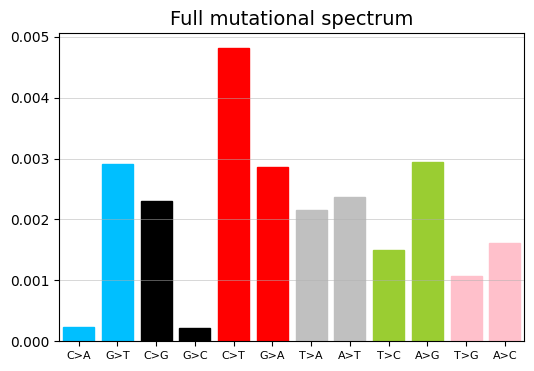

<Axes: title={'center': 'Full mutational spectrum'}>

In [102]:
_ = mu_est_series.reset_index()
_.columns = ['Mut', 'MutSpec']
plot_mutspec12(_)

In [108]:
(A@mu_est_series).rename('phi_est').to_frame().join(obs_freqs.rename('phi_obs')).corr()**2

,phi_est,phi_obs
phi_est,1.000000,0.415343
phi_obs,0.415343,1.000000
